In [1]:
# 경로설정
import sys
path = "C:\github/aide-analysis/"
path2 = 'C:\github/aide-analysis/notebook/temp_ljs/Develop/지주리포트Lite/실거래 이상값 제거 연구 및 추론/모듈 및 압축파일 보관 폴더'
sys.path.append(path)
sys.path.append(path2)

import os
import sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd())))
# 한글폰트
import os
import matplotlib.pyplot as plt
if os.name =='posix':
    plt.rc('font',family = 'ApplGothic')
else:
    plt.rc('font',family = 'Malgun Gothic')
    
# 경고출력문 제거
import warnings
warnings.filterwarnings("ignore")

# 모듈 import
import pandas as pd
import src
from src.openapi import KakaoLocalAPI as kakao
from openpyxl import load_workbook
from src.utils import insert_dataframe_to_excel_sheet
from src.sql import DatabaseHandler
from src.temp import *
from datetime import datetime
import datetime
from dateutil.relativedelta import relativedelta
from src.bigquery import BigqueryHandler
import seaborn as sns
import numpy as np
import statistics
from tqdm import tqdm
import config
from core.config import Config
import json
from datetime import datetime
import geopandas as gpd
from tqdm import tqdm
import folium
from src.bigquery import bigquery_client, bigquery
import geopandas as gpd
from shapely import wkt
from openpyxl import load_workbook
from src.utils import insert_dataframe_to_excel_sheet
from openpyxl.utils.dataframe import dataframe_to_rows
from difflib import SequenceMatcher
import openpyxl
import math
from 실거래전처리 import TradeProcessing
from dataclasses import dataclass
config = Config()
BH = BigqueryHandler()


# DataFrame 디스플레이 설정
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', 100)

In [2]:
docs = kakao.search_address('서울특별시 동대문구 휘경동 95-1')
bdongCode = docs['documents'][0]['address']['b_code'][:-2]
sigunguCode = docs['documents'][0]['address']['b_code'][:5]
lon = docs['documents'][0]['x']
lat = docs['documents'][0]['y']

In [21]:
# sql = f"""
# SELECT area.*, danji.longitude, danji.latitude,danji.useApproveYear, danji.totalHouseholdCount
# FROM `aidepartners.aide.complex_area_information_prod` AS area
# LEFT JOIN (SELECT complexNo, longitude, latitude, useApproveYear, totalHouseholdCount FROM `aidepartners.aide.complex_danji_information`) AS danji ON area.complexNo = danji.complexNo
# WHERE ST_DISTANCE(st_geogpoint({lon},{lat}), st_geogpoint(danji.longitude,danji.latitude),False)<=2000 and realEstateTypeCode IN ('APT','ABYG') AND area.areaSixGroupNo IN ("A0","A1")
# """
# df = BH.read_table(sql)

In [123]:
sql = f"""
SELECT area.*, danji.longitude,danji.sigunguCode, danji.bdongCode,  danji.latitude,danji.useApproveYear, danji.totalHouseholdCount,
       price.dealPrice, price.contractDate, (price.dealPrice*10000)/ area.supplyPyeong AS pricePerPyeong
FROM `aidepartners.aide.complex_area_information_prod` AS area
LEFT JOIN (SELECT complexNo, sigunguCode, bdongCode, longitude, latitude, useApproveYear, totalHouseholdCount FROM `aidepartners.aide.complex_danji_information`) AS danji ON area.complexNo = danji.complexNo
LEFT JOIN (SELECT complexNo, areaNo,dealPrice,contractDate  FROM `aidepartners.aide.complex_real_price_prod` WHERE tradeType = 'A1' AND contractDate >='2018-01-01') AS price ON area.complexNo = price.complexNo AND area.pyeongNo = price.areaNo
WHERE danji.sigunguCode = "{sigunguCode}" and realEstateTypeCode IN ('APT','ABYG') AND area.areaSixGroupNo IN ("A0","A1")

"""
df = BH.read_table(sql)

In [124]:
# 총세대수 100세대 이상
df = df[df['totalHouseholdCount']>=100].reset_index(drop =True)

In [125]:
# 필요한 컬럼 색인
df = df[['pnuCode','complexNo','complexName','useApproveYear','totalHouseholdCount','realEstateTypeCode','pyeongNo','supplyArea','jeonyongArea','householdCountByPyeong','jeonyongRate','areaSixGroupNo','entranceType','roomCount','bathroomCount','dealPrice','contractDate','pricePerPyeong']]

# 마포구 최근 5년내 건축된 단지들의 가격

In [126]:
df_recent = df[(df['jeonyongArea']>=30)&(df['useApproveYear']>="2018")]
a , b = df_recent.loc[-df_recent['dealPrice'].isna(),'complexNo'].unique()

In [127]:
df_a = df_recent[df_recent['complexNo']==a]
df_b = df_recent[df_recent['complexNo']==b]

Text(0.5, 1.0, '마포구 최근 5년내 건축된 단지 가격(휘경자이디센시아와 비슷한면적)')

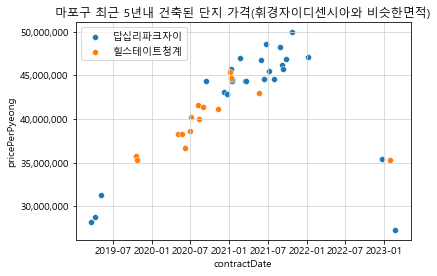

In [129]:
sns.scatterplot(df_a['contractDate'], df_a['pricePerPyeong'], label = df_a['complexName'].iloc[0])
sns.scatterplot(df_b['contractDate'], df_b['pricePerPyeong'], label = df_b['complexName'].iloc[0])

# y축 설정
current_values =plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

# grid 설정
plt.grid(axis = "y", c = "lightgray")
plt.grid(axis = "x", c = "lightgray")
plt.legend()
plt.title('마포구 최근 5년내 건축된 단지 가격(휘경자이디센시아와 비슷한면적)')


In [143]:
df_recent = df[(df['jeonyongArea']>=30)&(df['totalHouseholdCount']>=200)]
for i in list(df_recent.loc[-df_recent['dealPrice'].isna(),'complexNo'].unique()):
    test =df_recent.loc[df_recent['complexNo']==i]
    name = test['complexName'].iloc[0]
    year = test['useApproveYear'].iloc[0]
    area = test['jeonyongArea'].iloc[0]
    sedae = test['totalHouseholdCount'].iloc[0]
    sns.scatterplot(test['contractDate'], test['pricePerPyeong'], label = test['complexName'].iloc[0])
    # y축 설정
    current_values =plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

    # grid 설정
    plt.grid(axis = "y", c = "lightgray")
    plt.grid(axis = "x", c = "lightgray")
    plt.legend()
    plt.title(f'{name}단지 / 전용면적 {area}/ 사용승인일 {year}, 세대수{sedae}')
    plt.savefig(f'{name}단지.png')
    
    # 각 단지별로 시각화 하기 위한 코드
    fig = plt.gcf()
    plt.close(fig)